<h2> GANS Using CIFAR10 dataset which is similar to the FashionMNIST dataset </h2>
"""
<h4>The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.</h4>
"""

### A Deep Convolutional GAN (DCGAN) implementation for generating random images  using the CIFAR10 dataset.

In [ ]:
# !pip  install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipwidgets

In [1]:
import tensorflow as tf
print("Check my GPU", tf.config.list_physical_devices('GPU'))

Check my GPU [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

### Import the CIFAR10 dataset and inspect dataset

In [3]:
# only the training images is needed
(X_train, _), (_, _) = keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [4]:
print("Data shape", X_train.shape)

Data shape (50000, 32, 32, 3)


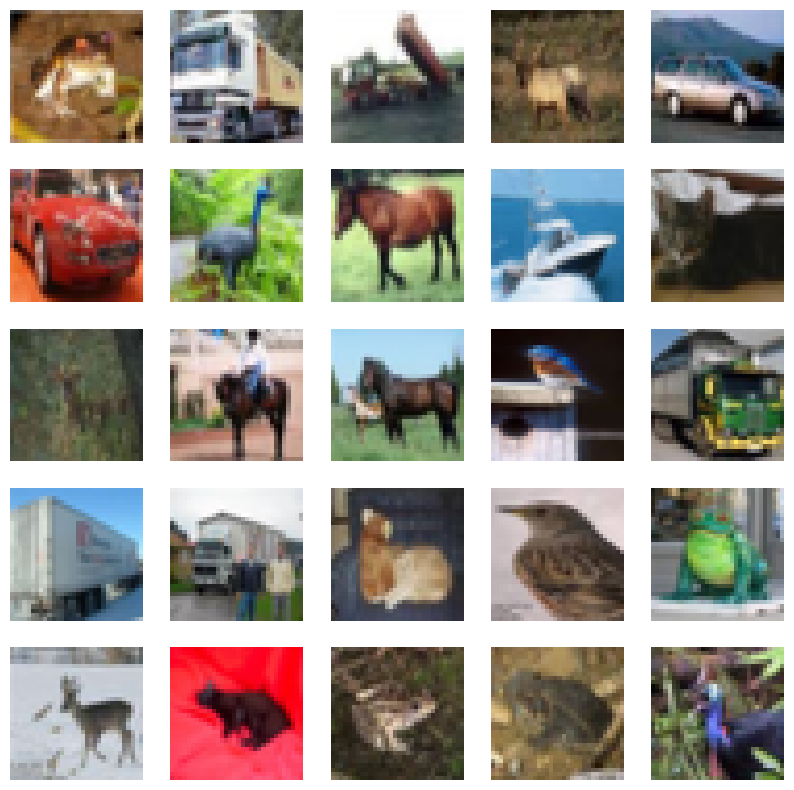

In [5]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.grid(False)
    plt.imshow(X_train[i])
    plt.axis("off")
plt.show()

<h2> Create a DataPipeline

In [6]:
X_train.shape[0]

50000

In [7]:
#  Normalize the data bcause the GAns work better in the range of [-1, 1] instead of the [0,225]
X_train = X_train.reshape(X_train.shape[0], 32, 32, 3).astype("float32")
X_train = (X_train - 127.5)/127.5

In [8]:
# create the buffer_size and teh batch_size

BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [9]:
X_train # View the train data

array([[[[-0.5372549 , -0.5137255 , -0.5058824 ],
         [-0.6627451 , -0.6392157 , -0.64705884],
         [-0.60784316, -0.62352943, -0.6627451 ],
         ...,
         [ 0.23921569,  0.03529412, -0.15294118],
         [ 0.19215687, -0.01960784, -0.2       ],
         [ 0.16078432, -0.02745098, -0.19215687]],

        [[-0.8745098 , -0.84313726, -0.84313726],
         [-1.        , -1.        , -1.        ],
         [-0.85882354, -0.9372549 , -1.        ],
         ...,
         [-0.03529412, -0.30980393, -0.5686275 ],
         [-0.06666667, -0.34901962, -0.60784316],
         [-0.04313726, -0.31764707, -0.5529412 ]],

        [[-0.8039216 , -0.8117647 , -0.8352941 ],
         [-0.8745098 , -0.94509804, -1.        ],
         [-0.6156863 , -0.7882353 , -0.9372549 ],
         ...,
         [-0.07450981, -0.34117648, -0.60784316],
         [-0.05882353, -0.34117648, -0.60784316],
         [-0.14509805, -0.42745098, -0.67058825]],

        ...,

        [[ 0.6313726 ,  0.33333334, -0

In [10]:
# Converting X_train into a Tensor flow dataset thus aftter batching the total number of epoch will be,
# 50000/256 = 195

# Create the tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [11]:
LATENT_DIM = 100
WEIGHT_UNIT = keras.initializers.RandomNormal(mean=0.01, stddev=0.02)
# mean --> helps to improve a more stable and faster training
# stddev --> helps GANS to generate shaarper images and ensures the network starts with balanced gradients

###  Create a Generator

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_generator():
    model = keras.Sequential([
        layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(LATENT_DIM,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        layers.Reshape((8, 8, 256)),

        # Modified: Reduced strides to (1, 1) in the first Conv2DTranspose layer
        layers.Conv2DTranspose(128, (3, 3), strides=(1, 1), padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2DTranspose(3, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

generator = build_generator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


###  Building Discriminator

In [13]:
def build_discriminator():
    model = keras.Sequential([
        layers.Conv2D(64, (5,5), strides=(2,2), padding="same", input_shape=[32,32,3]),
        layers.LeakyReLU(alpha=0.2), # Instantiate LeakyReLU as a layer with alpha
        # dropour prevent overfitting and improve generalization
        layers.Dropout(0.2),

        # First COnv2d layer: LEarn more complex feature from the images
        layers.Conv2D(128, (3,3), strides=(2,2), padding="same"),
        layers.LeakyReLU(alpha=0.2), # Instantiate LeakyReLU as a layer with alpha
        layers.Dropout(0.2),

        # Adjust the strides or kernel size in previous convolutional layers
        # or Add another Conv2D layer here to further downsample
        layers.Conv2D(256, (3,3), strides=(2,2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.2),


        # FLatten the 2D feature into a 1D vector for the Dense layer
        layers.Flatten(), # Flatten layer added to correct the shape before the Dense layer

        # Adjust the input shape of the Dense layer to match the output of Flatten
        layers.Dense(1, activation="sigmoid") # Input shape adjusted
    ])

    return model

discriminator = build_discriminator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Create the generator and Discriminator losses

In [14]:
# instantiate the losses.BinaryCrossEntropy
cross_entropy = keras.losses.BinaryCrossentropy()

In [15]:
def discriminator_loss(real_output, fake_output):
    # Claculates the loss when the discriminator classify fake images
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)

    # Calculates the loass when the discriminator classifies fake images
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    # Add the real and fake loss
    return real_loss + fake_loss



In [16]:
# define the generator loss function
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [17]:
# instatiate the Optimizers = Adam

generator_optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.7)
discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.7)

### Build a Subclss Model

In [18]:
# instatiate the class GAN and build functions
class GAN(keras.Model):
    def __init__(self, discriminator, generator):
        super(GAN, self).__init__()
        self.discriminator = discriminator #set discriminator model
        self.generator = generator # set generator model

    def compile(self, d_optmizer, g_optimizer, d_loss, g_loss):
        super(GAN, self).compile()
        self.d_optimizer = d_optmizer # set the discriminator optimizer
        self.g_optimizer = g_optimizer # set the generator optimizer
        self.d_loss = d_loss # set the discriminator loss
        self.g_loss = g_loss # set the generator loss

    def train_step(self, real_images):
        # Training logic
        batch_size = tf.shape(real_images)[0]

        # Train Discriminator
        noise = tf.random.normal([batch_size, LATENT_DIM])
        with tf.GradientTape() as d_tape:
            generated_images = self.generator(noise)
            real_output = self.discriminator(real_images)
            fake_output = self.discriminator(generated_images)
            d_loss = self.d_loss(real_output, fake_output)

        # computing the gradients for the discriminator based on its loss
        d_gradients = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))

        # Train Generator
        noise = tf.random.normal([batch_size, LATENT_DIM])
        with tf.GradientTape() as g_tape:
            generated_images = self.generator(noise)
            fake_output = self.discriminator(generated_images)
            g_loss = self.g_loss(fake_output)

        # computing the gradients for the generator based on its loss
        g_gradients = g_tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))
        return {"d_loss": d_loss, "g_loss": g_loss}


In [20]:
# Create an image callback class
class ImageCallback(keras.callbacks.Callback):
    def __init__(self, num_img=16, latent_dim=100): # Changed latent_dim to 128
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.seed = tf.random.normal([num_img, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            generated_images = self.model.generator(self.seed)
            generated_images = (generated_images * 127.5) + 127.5

            plt.figure(figsize=(10,10))
            for i in range(self.num_img):
                plt.subplot(4,4,i+1)
                plt.grid(False)
                plt.imshow(generated_images[i].numpy().astype("uint8"))
                plt.axis("off")
            plt.show()

### TRain the Dataset

In [21]:
EPOCH = 200

In [22]:
gan = GAN(discriminator=discriminator, generator=generator)
gan.compile(
    d_optmizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    d_loss=discriminator_loss,
    g_loss=generator_loss
)

Epoch 1/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - d_loss: 0.5910 - g_loss: 1.7174

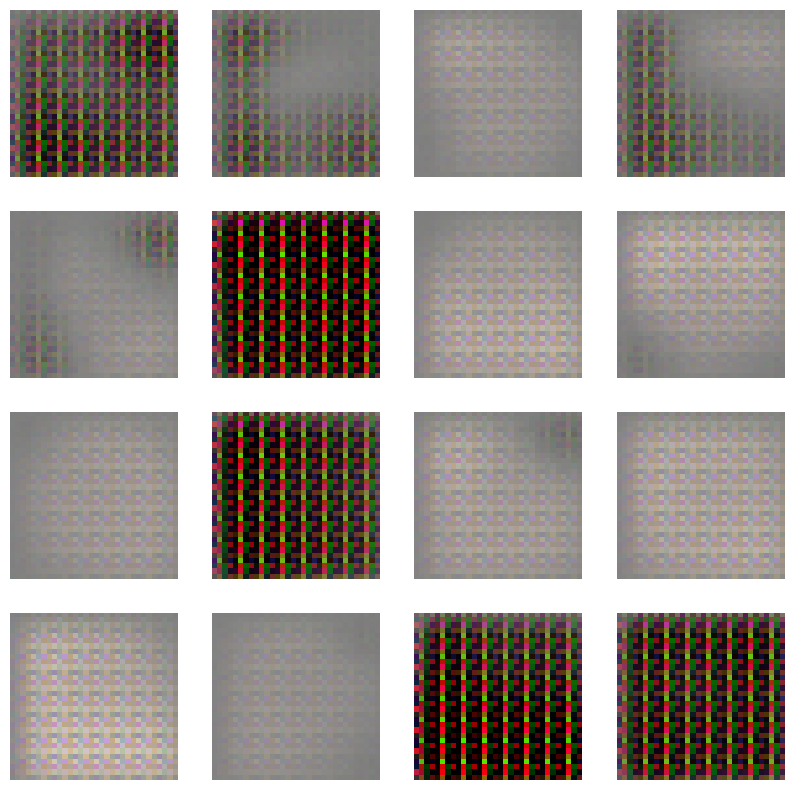

196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - d_loss: 0.5942 - g_loss: 1.7203
Epoch 2/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - d_loss: 0.6037 - g_loss: 2.6421
Epoch 3/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - d_loss: 0.6617 - g_loss: 2.1726
Epoch 4/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - d_loss: 0.8493 - g_loss: 1.4504
Epoch 5/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - d_loss: 0.9017 - g_loss: 1.3504
Epoch 6/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.0428 - g_loss: 1.3621
Epoch 7/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.0156 - g_loss: 1.2622
Epoch 8/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.0621 - g_loss: 1.1715
Epoch 9/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.1078 - g_loss: 1.2288
Epoch 10/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.0711 - g_loss: 1.1641
Epoch 11/200
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 1.1516 - g_loss: 1.1093

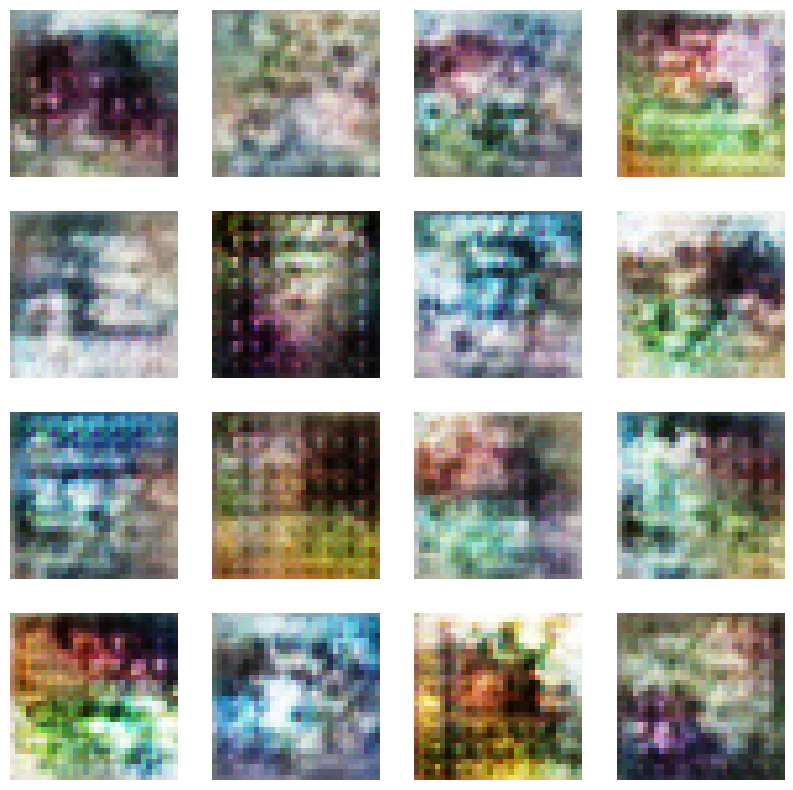

196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - d_loss: 1.1531 - g_loss: 1.1074
Epoch 12/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.1738 - g_loss: 0.9953
Epoch 13/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.1738 - g_loss: 0.9434
Epoch 14/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.1704 - g_loss: 1.0259
Epoch 15/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.1940 - g_loss: 1.0454
Epoch 16/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.1783 - g_loss: 1.0078
Epoch 17/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.1417 - g_loss: 1.0466
Epoch 18/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.1232 - g_loss: 1.0597
Epoch 19/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.1310 - g_loss: 1.0622
Epoch 20/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.1671 - g_loss: 1.0819
Epoch 21/200
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 1.1162 - g_loss: 1.0985

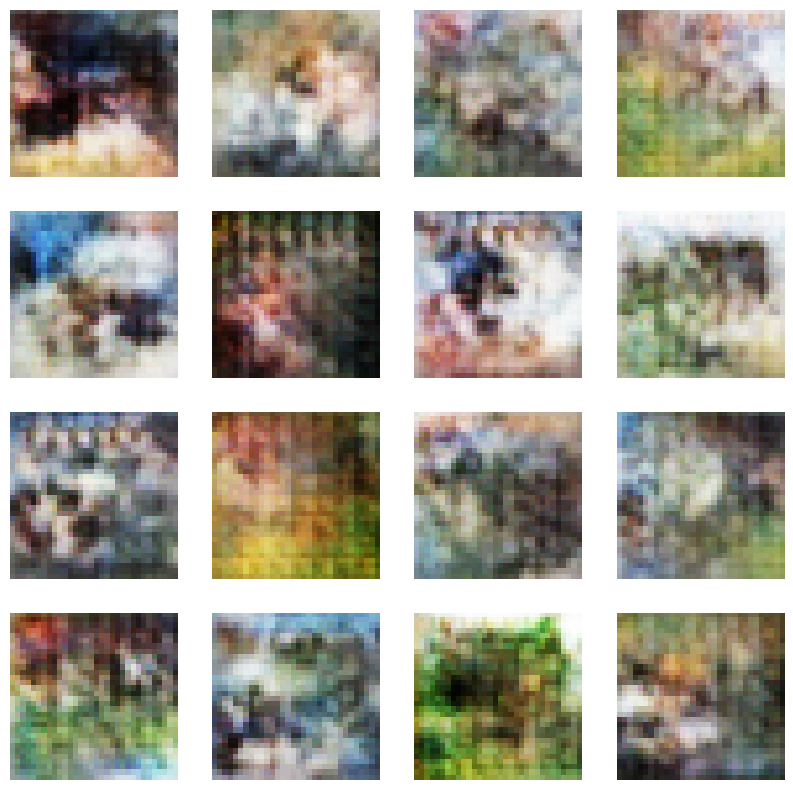

196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - d_loss: 1.1187 - g_loss: 1.0993
Epoch 22/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.1652 - g_loss: 1.0382
Epoch 23/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.1321 - g_loss: 1.0413
Epoch 24/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.1507 - g_loss: 1.0550
Epoch 25/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.1968 - g_loss: 1.0327
Epoch 26/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.1783 - g_loss: 1.0217
Epoch 27/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.1856 - g_loss: 1.0017
Epoch 28/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.1997 - g_loss: 1.0227
Epoch 29/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.2001 - g_loss: 0.9697
Epoch 30/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.2187 - g_loss: 0.9753
Epoch 31/200
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 1.1930 - g_loss: 0.9851

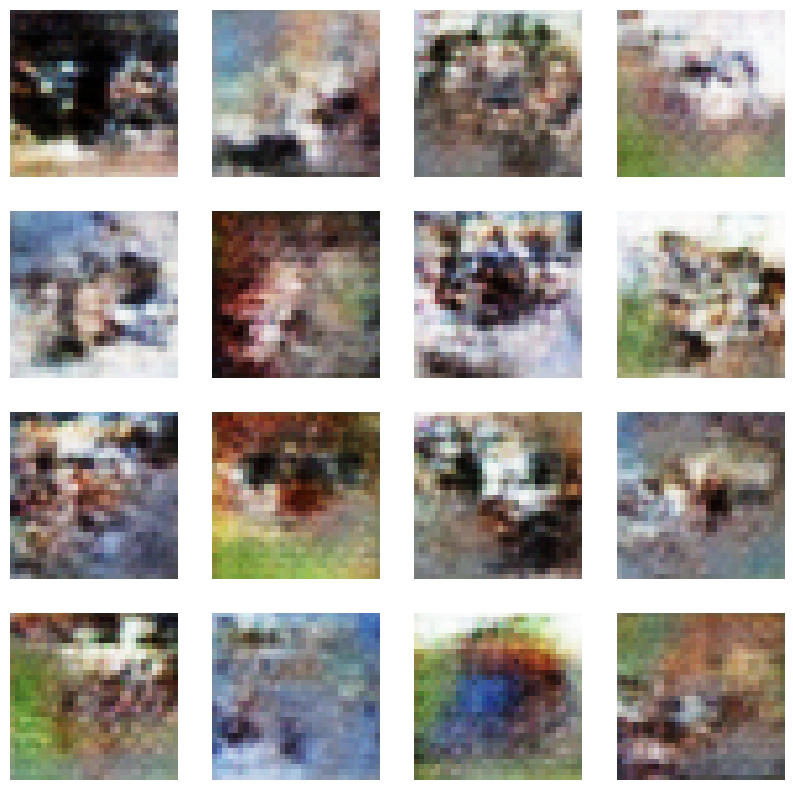

196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - d_loss: 1.1918 - g_loss: 0.9855
Epoch 32/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.2204 - g_loss: 0.9824
Epoch 33/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.1923 - g_loss: 0.9722
Epoch 34/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.1732 - g_loss: 1.0106
Epoch 35/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.1583 - g_loss: 1.0470
Epoch 36/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.1647 - g_loss: 1.0507
Epoch 37/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.1178 - g_loss: 1.1208
Epoch 38/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.1103 - g_loss: 1.1100
Epoch 39/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.0918 - g_loss: 1.1315
Epoch 40/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.0829 - g_loss: 1.2012
Epoch 41/200
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 1.0834 - g_loss: 1.1533

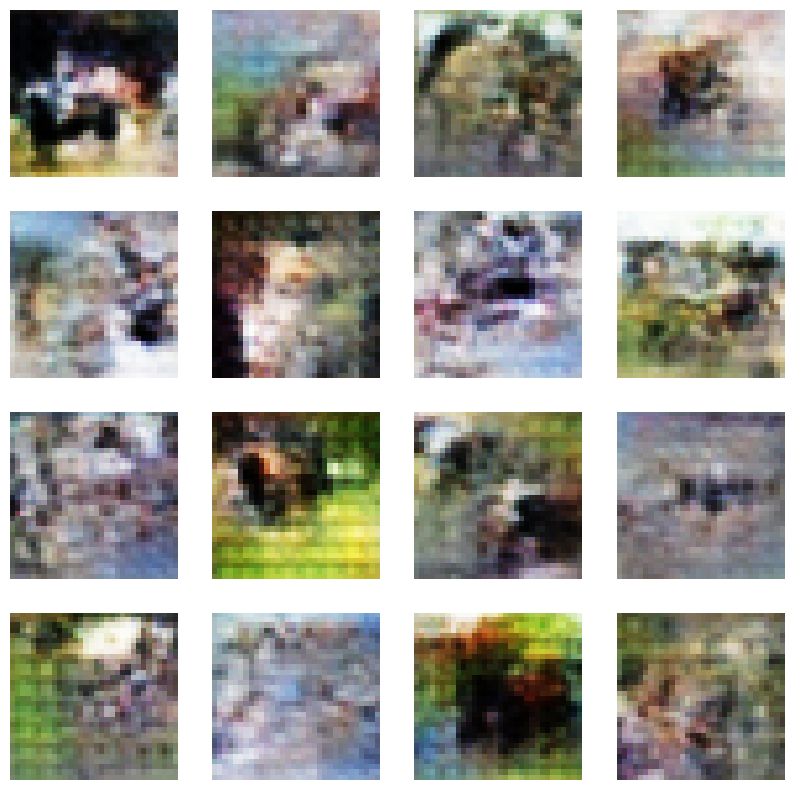

196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - d_loss: 1.0827 - g_loss: 1.1538
Epoch 42/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - d_loss: 1.0738 - g_loss: 1.1726
Epoch 43/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.0639 - g_loss: 1.1556
Epoch 44/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - d_loss: 1.0639 - g_loss: 1.2208
Epoch 45/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.0358 - g_loss: 1.1975
Epoch 46/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.0403 - g_loss: 1.2811
Epoch 47/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.0240 - g_loss: 1.2295
Epoch 48/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.0380 - g_loss: 1.2056
Epoch 49/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.0516 - g_loss: 1.1983
Epoch 50/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.0755 - g_loss: 1.1916
Epoch 51/200
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - d_loss: 1.0700 - g_loss: 1.1452

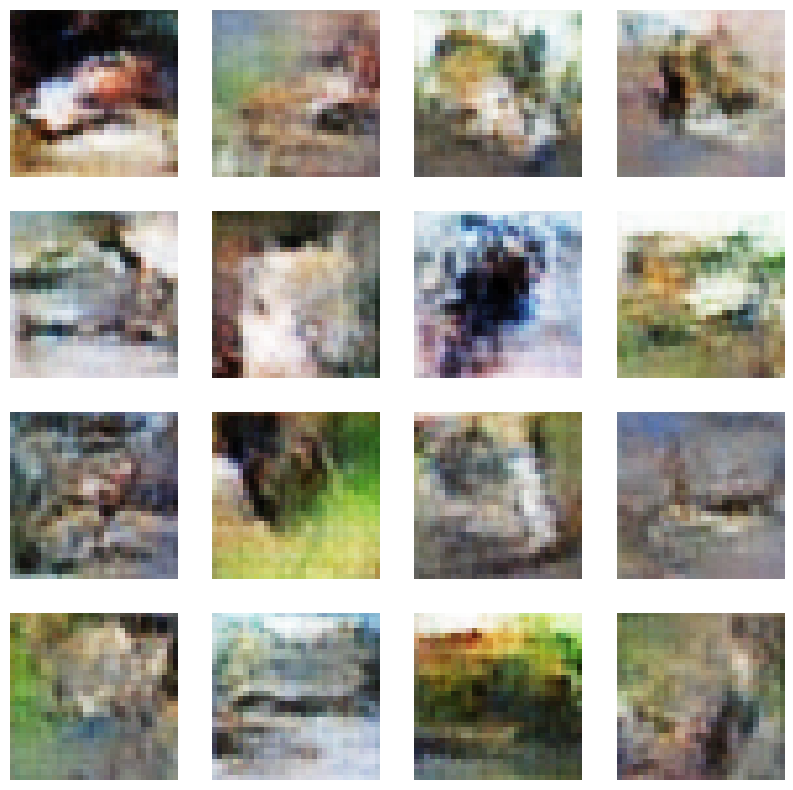

196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - d_loss: 1.0697 - g_loss: 1.1454
Epoch 52/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.0881 - g_loss: 1.1143
Epoch 53/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - d_loss: 1.1032 - g_loss: 1.1101
Epoch 54/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.1071 - g_loss: 1.0968
Epoch 55/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.1136 - g_loss: 1.1174
Epoch 56/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.1146 - g_loss: 1.0804
Epoch 57/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.1267 - g_loss: 1.0760
Epoch 58/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.1092 - g_loss: 1.0802
Epoch 59/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.1165 - g_loss: 1.0697
Epoch 60/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.1169 - g_loss: 1.0737
Epoch 61/200
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 1.1160 - g_loss: 1.0823

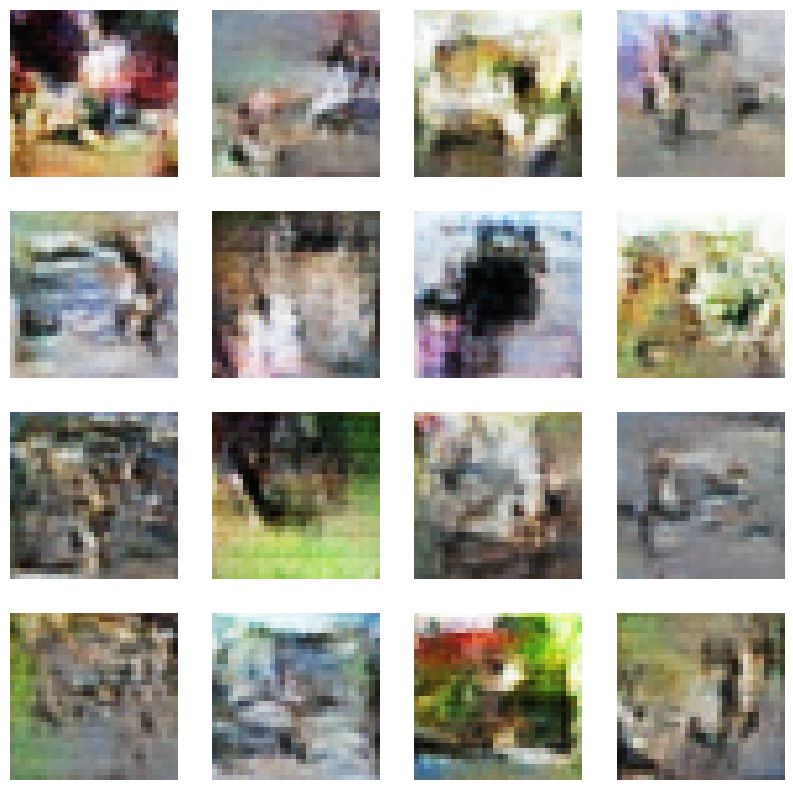

196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - d_loss: 1.1168 - g_loss: 1.0824
Epoch 62/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.0999 - g_loss: 1.0751
Epoch 63/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.1189 - g_loss: 1.1104
Epoch 64/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.0999 - g_loss: 1.0811
Epoch 65/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - d_loss: 1.1043 - g_loss: 1.0896
Epoch 66/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.1096 - g_loss: 1.0985
Epoch 67/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.1012 - g_loss: 1.0723
Epoch 68/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.1137 - g_loss: 1.0769
Epoch 69/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.1062 - g_loss: 1.0768
Epoch 70/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.1049 - g_loss: 1.1076
Epoch 71/200
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 1.1100 - g_loss: 1.0637

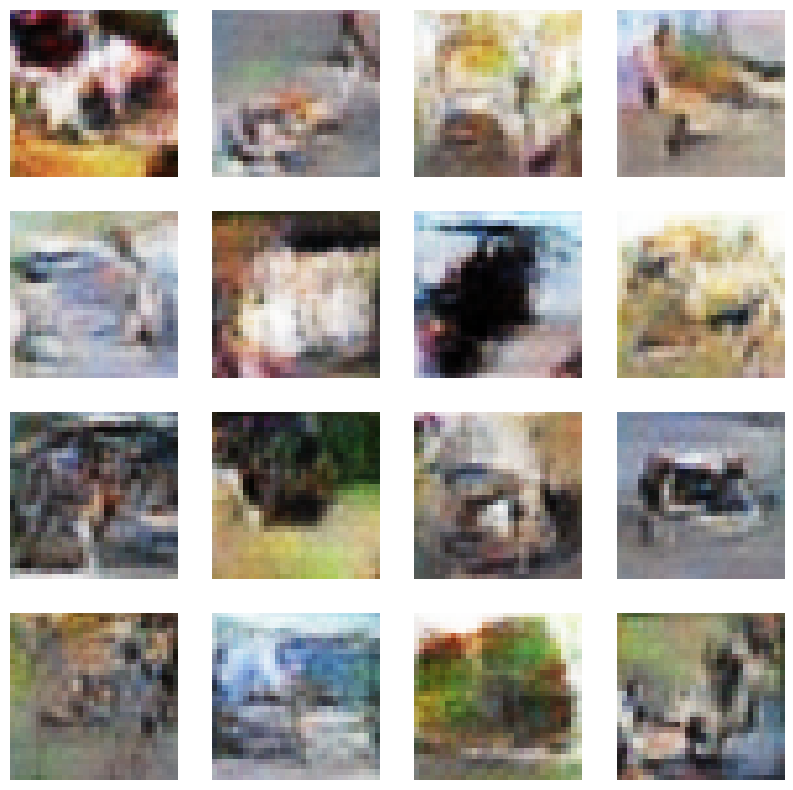

196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - d_loss: 1.1096 - g_loss: 1.0625
Epoch 72/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.1132 - g_loss: 1.0659
Epoch 73/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.1097 - g_loss: 1.0687
Epoch 74/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.1115 - g_loss: 1.0695
Epoch 75/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.1205 - g_loss: 1.0574
Epoch 76/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.1197 - g_loss: 1.0566
Epoch 77/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.1215 - g_loss: 1.0501
Epoch 78/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.1312 - g_loss: 1.0504
Epoch 79/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.1300 - g_loss: 1.0471
Epoch 80/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.1367 - g_loss: 1.0209
Epoch 81/200
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 1.1489 - g_loss: 1.0430

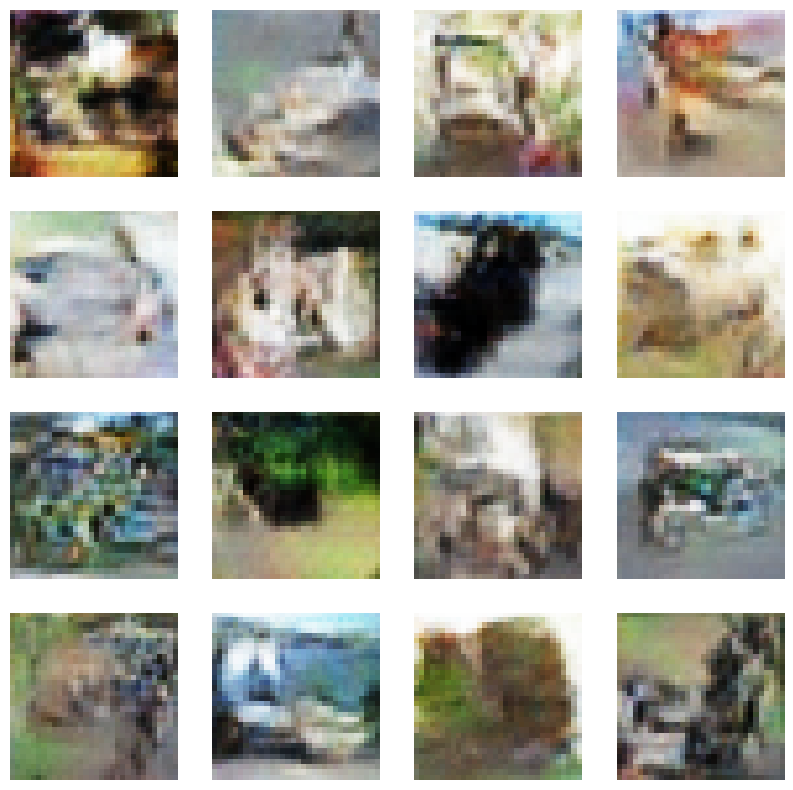

196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - d_loss: 1.1497 - g_loss: 1.0435
Epoch 82/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.1484 - g_loss: 1.0301
Epoch 83/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.1490 - g_loss: 1.0113
Epoch 84/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.1561 - g_loss: 1.0080
Epoch 85/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.1568 - g_loss: 1.0217
Epoch 86/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.1637 - g_loss: 0.9856
Epoch 87/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.1677 - g_loss: 1.0005
Epoch 88/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.1727 - g_loss: 0.9868
Epoch 89/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.1756 - g_loss: 0.9798
Epoch 90/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.1860 - g_loss: 1.0049
Epoch 91/200
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 1.1854 - g_loss: 0.9581

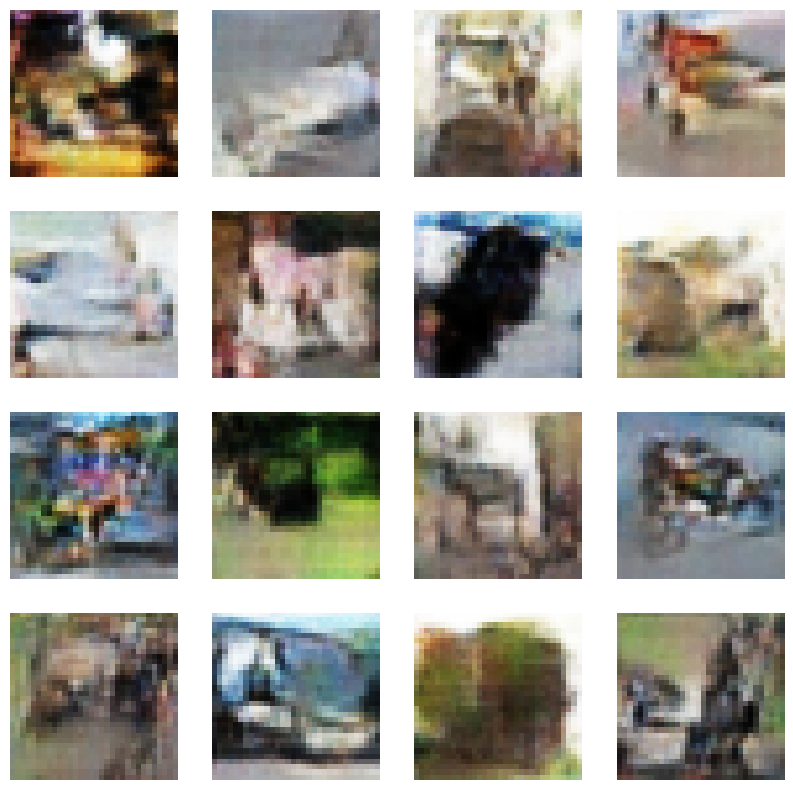

196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - d_loss: 1.1846 - g_loss: 0.9606
Epoch 92/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - d_loss: 1.1872 - g_loss: 0.9704
Epoch 93/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.1917 - g_loss: 0.9636
Epoch 94/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - d_loss: 1.1903 - g_loss: 0.9781
Epoch 95/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - d_loss: 1.1918 - g_loss: 0.9550
Epoch 96/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - d_loss: 1.2026 - g_loss: 0.9672
Epoch 97/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - d_loss: 1.2021 - g_loss: 0.9610
Epoch 98/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - d_loss: 1.2050 - g_loss: 0.9453
Epoch 99/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - d_loss: 1.2104 - g_loss: 0.9550
Epoch 100/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - d_loss: 1.2073 - g_loss: 0.9493
Epoch 101/200
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - d_loss: 1.2095 - g_loss: 0.9332

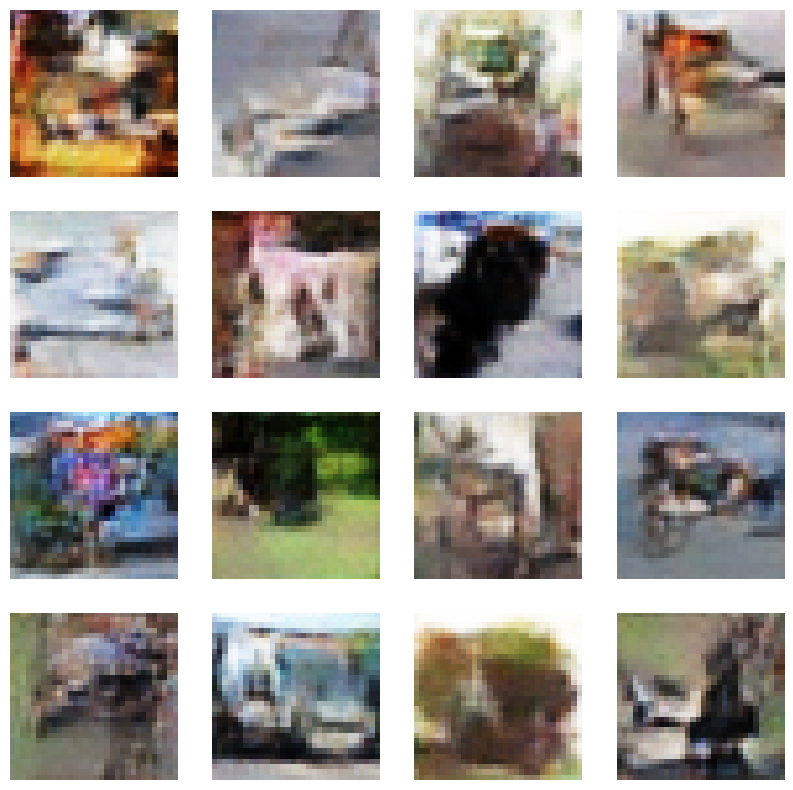

196/196 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - d_loss: 1.2109 - g_loss: 0.9330
Epoch 102/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.2115 - g_loss: 0.9248
Epoch 103/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - d_loss: 1.2146 - g_loss: 0.9409
Epoch 104/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - d_loss: 1.2194 - g_loss: 0.9402
Epoch 105/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.2222 - g_loss: 0.9162
Epoch 106/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - d_loss: 1.2166 - g_loss: 0.9343
Epoch 107/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.2305 - g_loss: 0.9364
Epoch 108/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - d_loss: 1.2201 - g_loss: 0.9058
Epoch 109/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.2290 - g_loss: 0.9177
Epoch 110/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - d_loss: 1.2278 - g_loss: 0.9125
Epoch 111/200
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 1.2331 - g_loss: 0.9034

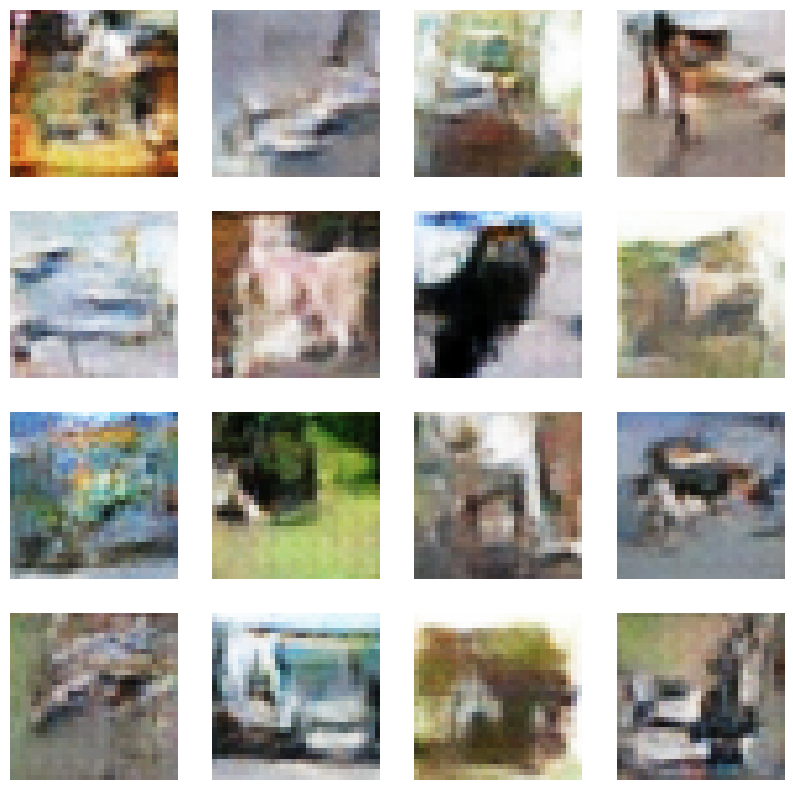

196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - d_loss: 1.2333 - g_loss: 0.9057
Epoch 112/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.2343 - g_loss: 0.9075
Epoch 113/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.2334 - g_loss: 0.9028
Epoch 114/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.2322 - g_loss: 0.9170
Epoch 115/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.2320 - g_loss: 0.8932
Epoch 116/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.2364 - g_loss: 0.8963
Epoch 117/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - d_loss: 1.2377 - g_loss: 0.8861
Epoch 118/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - d_loss: 1.2411 - g_loss: 0.9013
Epoch 119/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - d_loss: 1.2362 - g_loss: 0.8948
Epoch 120/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.2414 - g_loss: 0.8872
Epoch 121/200
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 1.2419 - g_loss: 0.8776

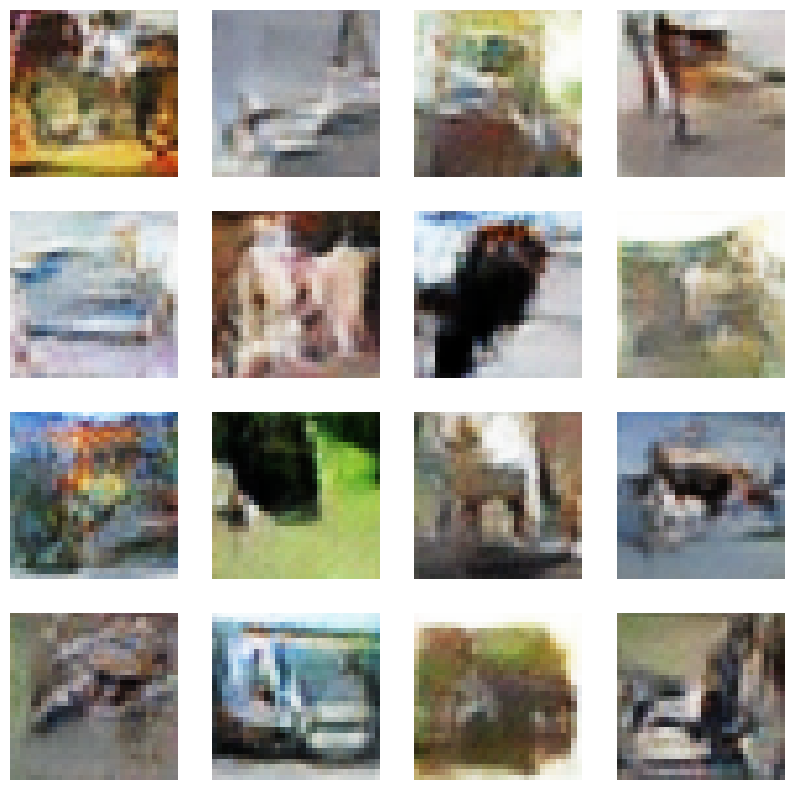

196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - d_loss: 1.2415 - g_loss: 0.8772
Epoch 122/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.2399 - g_loss: 0.9031
Epoch 123/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - d_loss: 1.2445 - g_loss: 0.8859
Epoch 124/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.2437 - g_loss: 0.8918
Epoch 125/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - d_loss: 1.2432 - g_loss: 0.8831
Epoch 126/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.2404 - g_loss: 0.9075
Epoch 127/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.2466 - g_loss: 0.8971
Epoch 128/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - d_loss: 1.2458 - g_loss: 0.8635
Epoch 129/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.2443 - g_loss: 0.8766
Epoch 130/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.2459 - g_loss: 0.8791
Epoch 131/200
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 1.2467 - g_loss: 0.8779

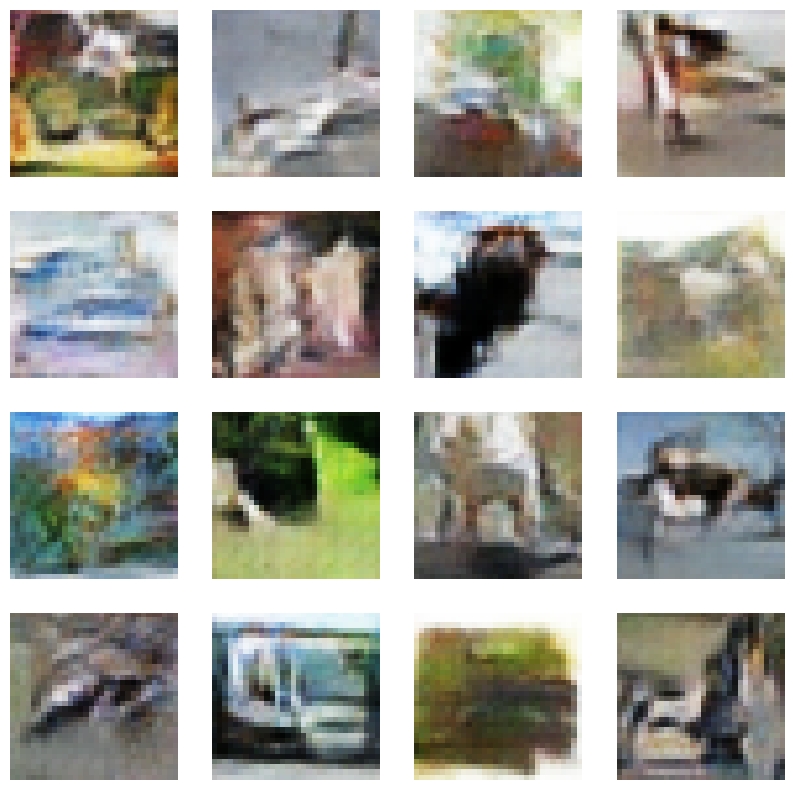

196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - d_loss: 1.2470 - g_loss: 0.8774
Epoch 132/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.2454 - g_loss: 0.8861
Epoch 133/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.2489 - g_loss: 0.8756
Epoch 134/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.2450 - g_loss: 0.8698
Epoch 135/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.2480 - g_loss: 0.8730
Epoch 136/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.2482 - g_loss: 0.8770
Epoch 137/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.2515 - g_loss: 0.8716
Epoch 138/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.2473 - g_loss: 0.8911
Epoch 139/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.2500 - g_loss: 0.8811
Epoch 140/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.2458 - g_loss: 0.8634
Epoch 141/200
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 1.2561 - g_loss: 0.9219

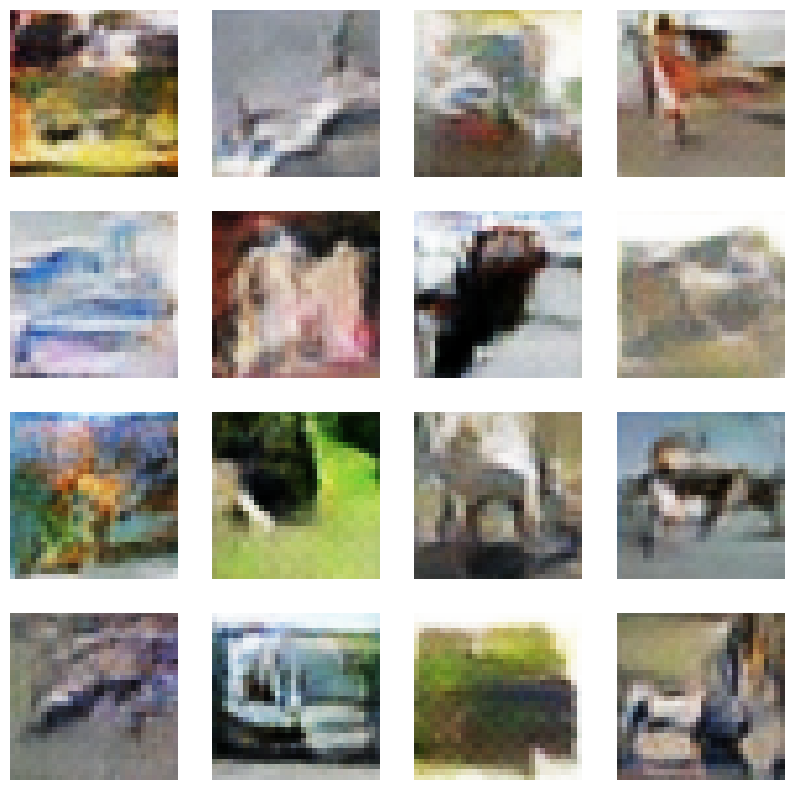

196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - d_loss: 1.2554 - g_loss: 0.9206
Epoch 142/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.2502 - g_loss: 0.8636
Epoch 143/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.2478 - g_loss: 0.8516
Epoch 144/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.2521 - g_loss: 0.8660
Epoch 145/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.2493 - g_loss: 0.8702
Epoch 146/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.2498 - g_loss: 0.8617
Epoch 147/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.2506 - g_loss: 0.8862
Epoch 148/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.2523 - g_loss: 0.8711
Epoch 149/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.2489 - g_loss: 0.8721
Epoch 150/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.2616 - g_loss: 0.9254
Epoch 151/200
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - d_loss: 1.2474 - g_loss: 0.8752

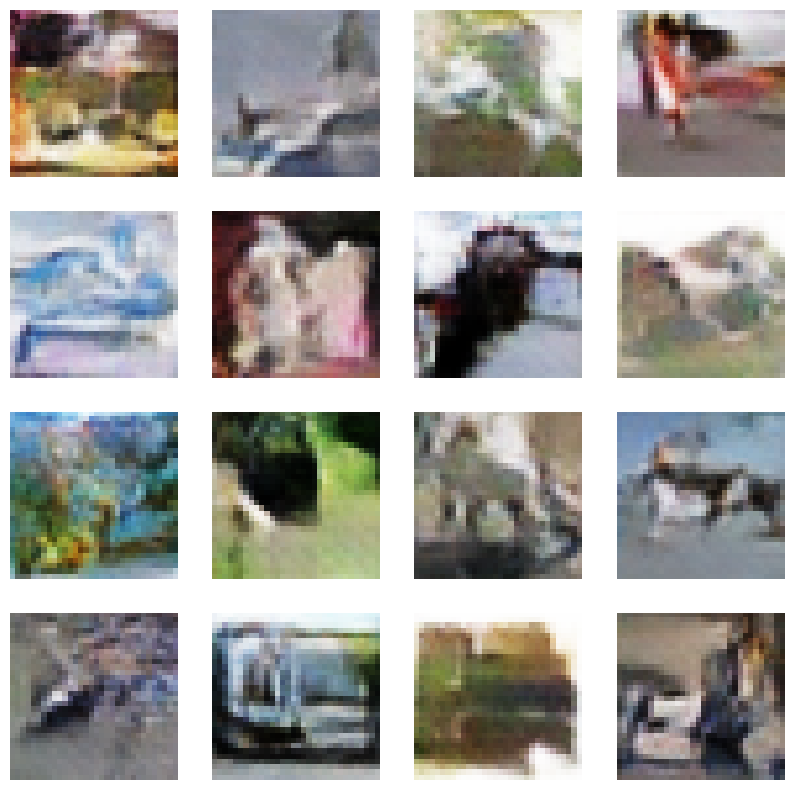

196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.2469 - g_loss: 0.8753
Epoch 152/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.2528 - g_loss: 0.8524
Epoch 153/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - d_loss: 1.2537 - g_loss: 0.8601
Epoch 154/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - d_loss: 1.2557 - g_loss: 0.8632
Epoch 155/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - d_loss: 1.2516 - g_loss: 0.8552
Epoch 156/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - d_loss: 1.2544 - g_loss: 0.8573
Epoch 157/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - d_loss: 1.2536 - g_loss: 0.8698
Epoch 158/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.2544 - g_loss: 0.8637
Epoch 159/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - d_loss: 1.2491 - g_loss: 0.8669
Epoch 160/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - d_loss: 1.2518 - g_loss: 0.8586
Epoch 161/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 1.2516 - g_loss: 0.8697

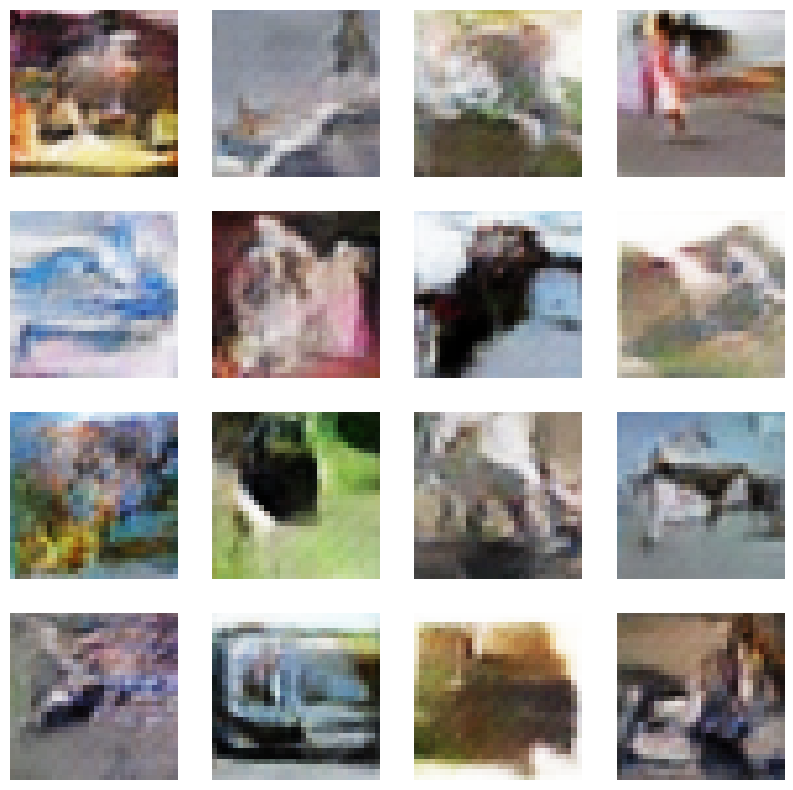

196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - d_loss: 1.2525 - g_loss: 0.8705
Epoch 162/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.2537 - g_loss: 0.8633
Epoch 163/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - d_loss: 1.2497 - g_loss: 0.8928
Epoch 164/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.2548 - g_loss: 0.8549
Epoch 165/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.2479 - g_loss: 0.8573
Epoch 166/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - d_loss: 1.2491 - g_loss: 0.8637
Epoch 167/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.2505 - g_loss: 0.8630
Epoch 168/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - d_loss: 1.2471 - g_loss: 0.8930
Epoch 169/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.2530 - g_loss: 0.8724
Epoch 170/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - d_loss: 1.2469 - g_loss: 0.8741
Epoch 171/200
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 1.2490 - g_loss: 0.8640

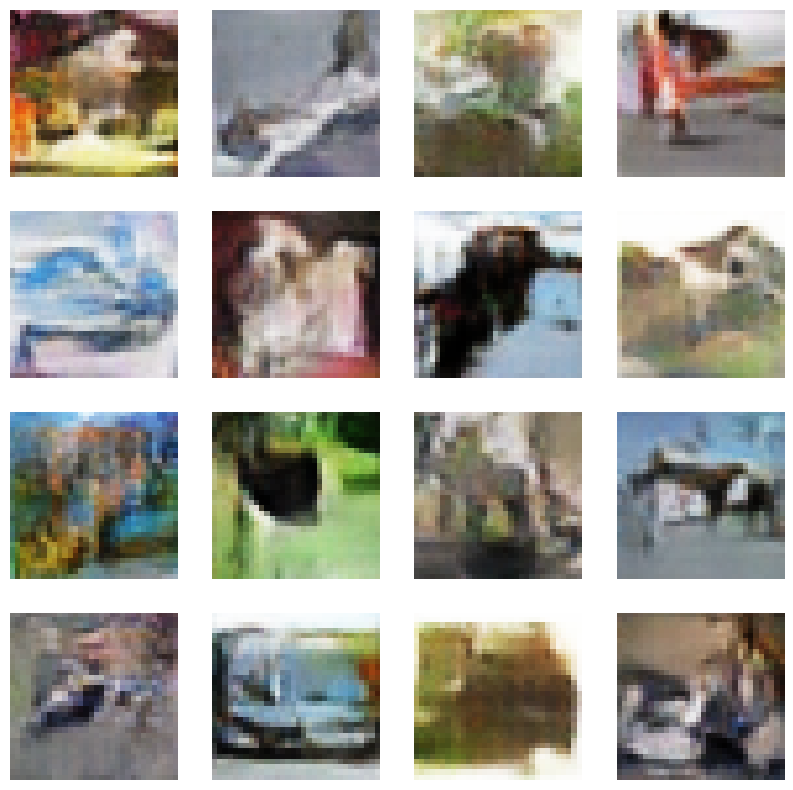

196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - d_loss: 1.2490 - g_loss: 0.8637
Epoch 172/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - d_loss: 1.2452 - g_loss: 0.8541
Epoch 173/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - d_loss: 1.2499 - g_loss: 0.8683
Epoch 174/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.2496 - g_loss: 0.8763
Epoch 175/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - d_loss: 1.2477 - g_loss: 0.8631
Epoch 176/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - d_loss: 1.2461 - g_loss: 0.8750
Epoch 177/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - d_loss: 1.2519 - g_loss: 0.8727
Epoch 178/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.2481 - g_loss: 0.8632
Epoch 179/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - d_loss: 1.2464 - g_loss: 0.8634
Epoch 180/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - d_loss: 1.2473 - g_loss: 0.8715
Epoch 181/200
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 1.2431 - g_loss: 0.8663

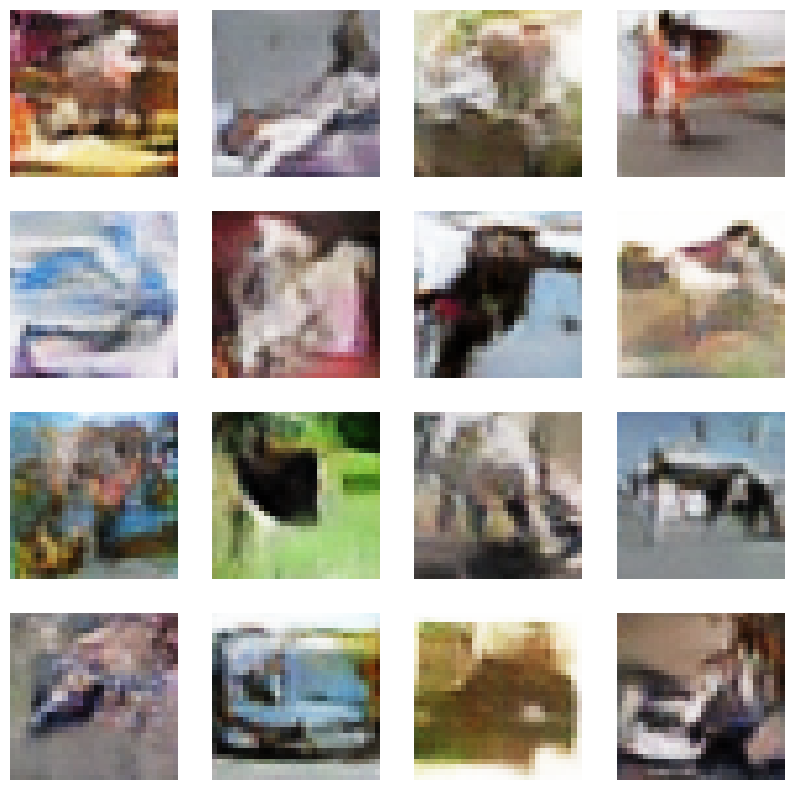

196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - d_loss: 1.2429 - g_loss: 0.8638
Epoch 182/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.2580 - g_loss: 0.8543
Epoch 183/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.2449 - g_loss: 0.8602
Epoch 184/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - d_loss: 1.2450 - g_loss: 0.8979
Epoch 185/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - d_loss: 1.2477 - g_loss: 0.8846
Epoch 186/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.2473 - g_loss: 0.8647
Epoch 187/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - d_loss: 1.2505 - g_loss: 0.8677
Epoch 188/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - d_loss: 1.2467 - g_loss: 0.8619
Epoch 189/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.2456 - g_loss: 0.8644
Epoch 190/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - d_loss: 1.2487 - g_loss: 0.8779
Epoch 191/200
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 1.2429 - g_loss: 0.8644

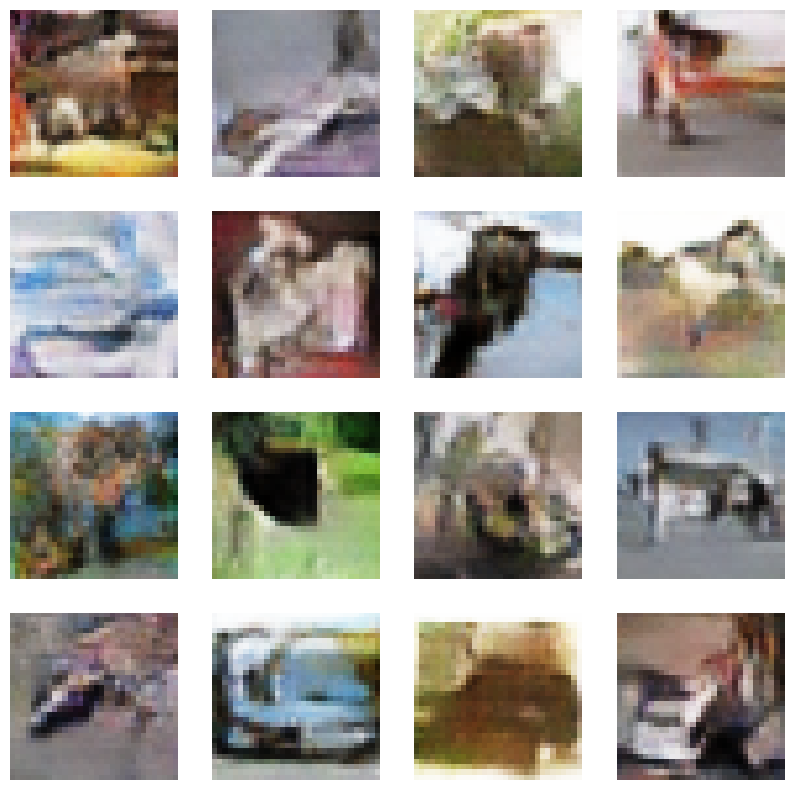

196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - d_loss: 1.2434 - g_loss: 0.8635
Epoch 192/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.2428 - g_loss: 0.8698
Epoch 193/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.2483 - g_loss: 0.8632
Epoch 194/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.2483 - g_loss: 0.9083
Epoch 195/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.2412 - g_loss: 0.8542
Epoch 196/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.2408 - g_loss: 0.8736
Epoch 197/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - d_loss: 1.2431 - g_loss: 0.8748
Epoch 198/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.2446 - g_loss: 0.8597
Epoch 199/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - d_loss: 1.2510 - g_loss: 0.8704
Epoch 200/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - d_loss: 1.2399 - g_loss: 0.8940


In [23]:
history = gan.fit(train_dataset, epochs=EPOCH, callbacks=[ImageCallback()])

### Evaluate the Model and save it

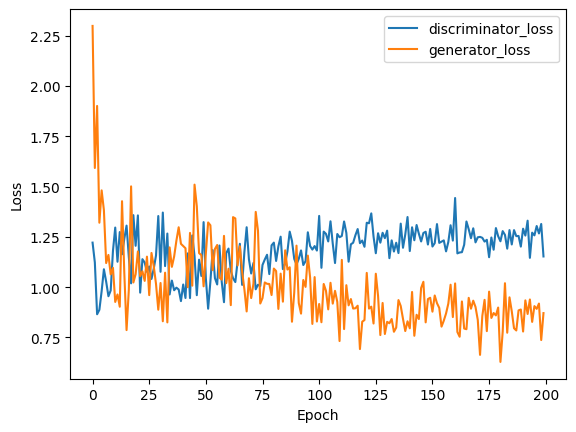

In [24]:
plt.plot(history.history['d_loss'], label='discriminator_loss')
plt.plot(history.history['g_loss'], label='generator_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
# Save model into an HS file
gan.save('dcgan_image.h5')

### CONCLUSION

<h1> <B>CHALLENGES AND POSSIBLE SOLUTIONS</H1>


<h3> 1. Training the model with more epochs will improve the ability of the GAN to generate images as clear as the dataset.</h3>

<h3> 2. If the GPU power of the machine used in developing the model is strong, i suggest a better apporach using WGANs in generating images but with a high computational cost.</h3>

<h3> 3. The blurry imageb in the dataset is the reason for a longer training time needed for themodel to understand the image to generate more images.</h3>

